In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
X_train = pd.read_csv('../input/digit-recognizer/train.csv')
X_test = pd.read_csv('../input/digit-recognizer/test.csv')

#Remove rows with missing target, separate target from predictors
X_train.dropna(axis=0, subset=['label'], inplace=True)
y_train = X_train.label
X_train.drop(['label'], axis=1, inplace=True)

In [2]:
X_train

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X_train.shape

(42000, 784)

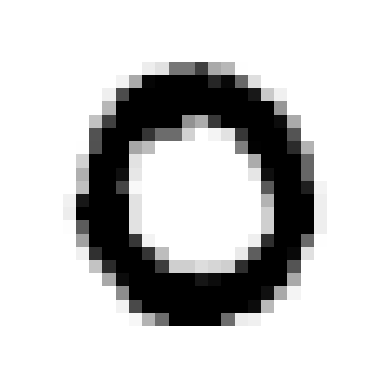

In [4]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
# X is a pandas DataFrame, convert to numpy array first
X_train_arr = X_train.to_numpy()
y_train_arr = y_train.to_numpy()

second_digit = X_train_arr[1]
plot_digit(second_digit)
plt.show()

In [5]:
y_train_arr[1]

0

# Multilabel Classification
Let's build a classifier using `KNeighboursClassifier` that achieves over 97% accuracy on the test set.
I will try `HalvingRandomSearchCV` to find good hyperparameter values (the `weights` and `n_neighbors` hyperparameters)
To speed up the search, let's train only the first 10000 images:

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint

param_distribs = {'weights': ["uniform", "distance"], 'n_neighbors': randint(low=3, high=10)}

knn_clf = KNeighborsClassifier()
rnd_search = HalvingRandomSearchCV(knn_clf, param_distribs, cv=5, random_state=42)
rnd_search.fit(X_train[:10000], y_train[:10000])

HalvingRandomSearchCV(estimator=KNeighborsClassifier(),
                      param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ba51a2b4e80>,
                                           'weights': ['uniform', 'distance']},
                      random_state=42)

In [7]:
rnd_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [8]:
rnd_search.best_score_

0.9476543209876542

In [9]:
rnd_search.best_estimator_.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

# Data Augmentation
Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. 
Artificially grow the dataset by creating 4 shifted copies (1 per direction) and add them to the training set. 
Let's try rotating it as well (45 degrees, left and right).

In [10]:
from scipy.ndimage import shift, rotate

def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    # The input is extended by filling all values beyond the edge with the same constant value, defined by the cval parameter.
    # So here we fill the edges with white pixels (0 intensity)
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    # flatten the array
    return shifted_image.reshape([-1])

def rotate_image(image, angle):
    image = image.reshape(28, 28)
    rot_image = rotate(image, angle, reshape=False, cval=0, mode="constant")
    return rot_image.reshape([-1])

Let's check that it works:

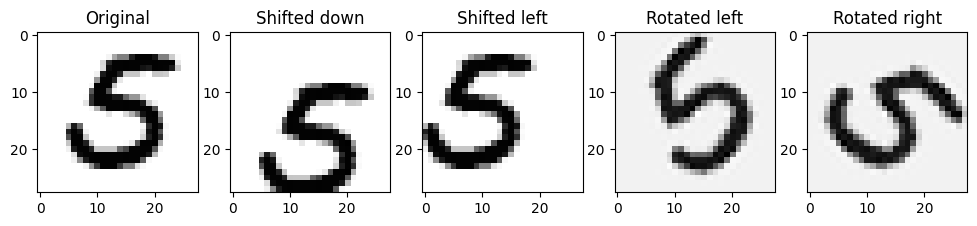

In [13]:
img = X_train_arr[900] # Just a random image
shifted_image_down = shift_image(img, 0, 5)
shifted_image_left = shift_image(img, -5, 0)
rot_image_left = rotate_image(img, 45)
rot_image_right = rotate_image(img, -45)

plt.figure(figsize=(12, 5))
plt.subplot(151)
plt.title("Original")
plt.imshow(img.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(152)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(153)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(154)
plt.title("Rotated left")
plt.imshow(rot_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(155)
plt.title("Rotated right")
plt.imshow(rot_image_right.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

Looks good! Now let's create an augmented training set by shifting every image left, right, up and down by one pixel, and also rotating the images left and right by 45 degrees (6 extra images):

In [17]:
X_train_augmented = [img for img in X_train_arr]
y_train_augmented = [label for label in y_train_arr]
tuples = zip(X_train_arr, y_train_arr)

for dx, dy in ((-1, 0), (1, 0), (0, -1), (0, 1)):
    for image, label in tuples:
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
        
for angle in (45, -45):
    for image, label in tuples:
        X_train_augmented.append(rotate_image(image, angle))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [20]:
len(X_train_augmented)

84000

Let's shuffle the augmented training set, or else all shifted images will be grouped together:

In [22]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

Now let's train the model using the best hyperparameters we found in the previous exercise:

In [23]:
knn_clf = KNeighborsClassifier(**rnd_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

# Submit predictions

In [25]:
final_model = knn_clf

X_test_arr = X_test.to_numpy()
preds_test = final_model.predict(X_test_arr)
output = pd.DataFrame({'ImageId': X_test.index+1,
                       'Label': preds_test})
output.to_csv('submission.csv', index=False)